# Task 2: RNN application -- Tweet Sentiment Analysis

In [134]:
# Import modules
from __future__ import print_function
import tensorflow as tf
import numpy as np
import json
import time
import matplotlib.pyplot as plt
import pickle

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load data

In [135]:
with open("./tweets_data/vocabulary.pkl", "rb") as f:
    vocabulary = pickle.load(f)

# load our data and separate it into tweets and labels
train_data = json.load(open('tweets_data/trainTweets_preprocessed.json', 'r'))
train_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),train_data))
train_tweets = np.array([t[0] for t in train_data])
train_labels = np.array([int(t[1]) for t in train_data])

test_data = json.load(open('tweets_data/testTweets_preprocessed.json', 'r'))
test_data = list(map(lambda row:(np.array(row[0],dtype=np.int32),str(row[1])),test_data))
test_tweets = np.array([t[0] for t in test_data])
test_labels = np.array([int(t[1]) for t in test_data])

print("size of original train set: {}".format(len(train_tweets)))
print("size of original test set: {}".format(len(test_tweets)))

# only select first 1000 test sample for test
test_tweets = test_tweets[:1000]
test_labels = test_labels[:1000]

print("*"*100)
print("size of train set: {}, #positive: {}, #negative: {}".format(len(train_tweets), np.sum(train_labels), len(train_tweets)-np.sum(train_labels)))
print("size of test set: {}, #positive: {}, #negative: {}".format(len(test_tweets), np.sum(test_labels), len(test_tweets)-np.sum(test_labels)))

# show text of the idx-th train tweet
# The 'padtoken' is used to ensure each tweet has the same length
idx = 100
train_text = [vocabulary[x] for x in train_tweets[idx]]
print(train_text)
sentiment_label = ["negative", "positive"]
print("sentiment: {}".format(sentiment_label[train_labels[idx]]))

size of original train set: 60000
size of original test set: 20000
****************************************************************************************************
size of train set: 60000, #positive: 30055, #negative: 29945
size of test set: 1000, #positive: 510, #negative: 490
['it', 'will', 'help', 'relieve', 'your', 'stress', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken', 'padtoken']
sentiment: positive


## Part 1: LSTM Encoder

### train a single-layer lstm network

First of all, we'll build a single-layer LSTM network for the analysis. The network structure is the following:

![](./img/singleLSTM.png)

<span style="color:red">__TODO:__</span> Below, we've defined the network for you. Please read the code carefully to make sure you understand it. Then, please write a training function to train this network. The settings are:

1. Train the network for 1000 iterations. In each iteration, use batch_size samples to train the network.
2. For every 50 iterations, apply the network on the test set, and print out the test accuracy and mean loss.

With these settings, what accuracy could you get? You can try to change some stuff in the network to see if you could get a better accuracy (this is optional).

In [138]:
# define a linear layer, y = x*w + b
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b


In [139]:
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [140]:
# Training function
num_steps = train_tweets.shape[0]//batch_size
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        # TODO: get data for a batch
        batch_tweets = train_tweets[batch_size*step:batch_size*(step+1)]
        batch_labels = train_labels[batch_size*step:batch_size*(step+1)]

        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer,loss,acc], feed_dict={tweets: batch_tweets, labels: batch_labels})

        if (step % 50 == 0):
            # TODO: get test accuracy and loss, and print them out.
            num_batches=test_tweets.shape[0]//batch_size
            test_loss_sum=[]
            test_acc_sum=[]
            test_acc_mean=0
            test_loss_=0
            test_loss_mean=0
            for i in range(num_batches):
                batch_test_tweets = test_tweets[batch_size*i:batch_size*(i+1)]
                batch_test_labels = test_labels[batch_size*i:batch_size*(i+1)]
                test_acc,test_loss = sess.run([acc,loss], feed_dict={tweets: batch_test_tweets, labels: batch_test_labels})
                test_loss_sum.append(test_loss)
                test_acc_sum.append(test_acc)
            test_loss_mean=np.mean(test_loss_sum)
            test_loss_=np.sum(test_loss_sum)
            
            test_acc_mean=np.mean(test_acc_sum)
            
            print('test acc = {}, test mean loss = {}, test total loss={}'.format(test_acc_mean*100,test_loss_mean,test_loss_))
  

test acc = 49.47916567325592, test mean loss = 0.6930140852928162, test total loss=10.395211219787598
test acc = 63.12500238418579, test mean loss = 0.6439870595932007, test total loss=9.659806251525879
test acc = 67.1875, test mean loss = 0.5951756238937378, test total loss=8.927634239196777
test acc = 70.41666507720947, test mean loss = 0.5875390768051147, test total loss=8.81308650970459
test acc = 72.1875011920929, test mean loss = 0.562333345413208, test total loss=8.4350004196167
test acc = 72.1875011920929, test mean loss = 0.544240415096283, test total loss=8.163606643676758
test acc = 72.70833253860474, test mean loss = 0.5419207215309143, test total loss=8.12881088256836
test acc = 70.83333134651184, test mean loss = 0.5585010051727295, test total loss=8.377514839172363
test acc = 73.64583611488342, test mean loss = 0.5359480381011963, test total loss=8.039220809936523
test acc = 73.64583611488342, test mean loss = 0.5276620388031006, test total loss=7.91493034362793
test acc

### train a two-layer lstm network

Next, we look at a slightly more difficult network structure: a double-layer LSTM. The output of the first LSTM cell is propagated to the second LSTM cell. We only need to make small modifications to the previous network to construct this one.

![](./img/doubleLSTM.png)

<span style="color:red">__TODO:__</span> Define this double-layer LSTM in the below notebook cell. You can copy the single-layer network code and make changes to it. After that, train the network using the function you just wrote.

Hint: Use **tf.contrib.rnn.MultiRNNCell**. You'll find there are only 2-3 lines of code that need to be changed.

In [ ]:
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b



In [141]:
# YOUR DOUBLE-LAYER LSTM Here

# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64

# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

tweets_onehot = tf.one_hot(tweets, depth=vocab_size, axis=-1)

# define the lstm cell
lstm_cell_1 = tf.contrib.rnn.LSTMCell(hidden_size)
lstm_cell_2 = tf.contrib.rnn.LSTMCell(hidden_size)

#lstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell_1]*2)
lstm_cell = tf.contrib.rnn.MultiRNNCell([lstm_cell_1,lstm_cell_2])

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, tweets_onehot, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1][-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [142]:
# YOUR TRAINING HERE
# Training function
num_steps = train_tweets.shape[0]//batch_size
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for step in range(num_steps):
        # TODO: get data for a batch
        batch_tweets = train_tweets[batch_size*step:batch_size*(step+1)]
        batch_labels = train_labels[batch_size*step:batch_size*(step+1)]

        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer,loss,acc], feed_dict={tweets: batch_tweets, labels: batch_labels})

        if (step % 50 == 0):
            # TODO: get test accuracy and loss, and print them out.
            num_batches=test_tweets.shape[0]//batch_size
            test_loss_sum=[]
            test_acc_sum=[]
            test_acc_mean=0
            test_loss_=0
            test_loss_mean=0
            for i in range(num_batches):
                batch_test_tweets = test_tweets[batch_size*i:batch_size*(i+1)]
                batch_test_labels = test_labels[batch_size*i:batch_size*(i+1)]
                test_acc,test_loss = sess.run([acc,loss], feed_dict={tweets: batch_test_tweets, labels: batch_test_labels})
                test_loss_sum.append(test_loss)
                test_acc_sum.append(test_acc)
            test_loss_mean=np.mean(test_loss_sum)
            test_loss_=np.sum(test_loss_sum)
            
            test_acc_mean=np.mean(test_acc_sum)
            
            print('test acc = {}, test mean loss = {}, test total loss={}'.format(test_acc_mean*100,test_loss_mean,test_loss_))
            
            

test acc = 55.000001192092896, test mean loss = 0.6926660537719727, test total loss=10.38999080657959
test acc = 65.52083492279053, test mean loss = 0.6253927946090698, test total loss=9.380891799926758
test acc = 67.81250238418579, test mean loss = 0.5864055752754211, test total loss=8.796083450317383
test acc = 70.6250011920929, test mean loss = 0.579820990562439, test total loss=8.697315216064453
test acc = 72.91666865348816, test mean loss = 0.5467126965522766, test total loss=8.200690269470215
test acc = 74.47916865348816, test mean loss = 0.532818078994751, test total loss=7.9922709465026855
test acc = 74.47916865348816, test mean loss = 0.5344914793968201, test total loss=8.017372131347656
test acc = 72.60416746139526, test mean loss = 0.5489180088043213, test total loss=8.233770370483398
test acc = 75.62500238418579, test mean loss = 0.5229235291481018, test total loss=7.843852996826172
test acc = 73.95833134651184, test mean loss = 0.532448410987854, test total loss=7.98672580

## Part 2: Embedding Lookup layer

![](./img/embedding.png)

###  Define an embedding layer

It's not hard to imagine in the previous practices, the input we fed in are very sparse because each word was represented as a one-hot vector. This makes it difficult for the network to understand what story the input data is telling. 

Word embedding: instead of using a one-hot vector to represent each word, we can add an word embedding matrix in which each word is represented as a low-dimensional vector. Note that this representation is not sparse any more, because we're working in a continuous vector space now. Words that share similar/related semantic meaning should be 'close to each other' in this vector space (we could define a distance measure to estimate the closeness). 

[https://www.tensorflow.org/tutorials/word2vec](https://www.tensorflow.org/tutorials/word2vec)

<span style="color:red">__TODO:__</span> Take a look at the website above, and write a function to do the embedding. The website itself is a very good tutorial.

Hint: Use **tf.nn.embedding_lookup**

In [143]:
def embedding(input_, vocab_size, output_size, name):
    """
    1. Define an embedding matrix
    2. return both the lookup results and the embedding matrix.
    """
    with tf.variable_scope(name):
        embedding_matrix=tf.get_variable("emb_matrix",initializer=tf.random_uniform([vocab_size,output_size],minval=-1,maxval=1))
    embeddings=tf.nn.embedding_lookup(embedding_matrix,input_)
    return embedding_matrix,embeddings
# YOUR CODE HERE

### Train a single lstm network with embedding layer

<span style="color:red">__TODO:__</span> Build a single-layer LSTM network according to the network structure. Then, train the network with the training function you wrote.

In [ ]:
def linear(input_, output_size, name, init_bias=0.0):
    shape = input_.get_shape().as_list()
    with tf.variable_scope(name):
        init = tf.truncated_normal([shape[-1], output_size], mean=0.0, stddev=1.0 / shape[-1]**0.5)
        W = tf.get_variable("weight", initializer=init)
    if init_bias is None:
        return tf.matmul(input_, W)
    with tf.variable_scope(name):
        b = tf.get_variable("bias", [output_size], initializer=tf.constant_initializer(init_bias))
    return tf.matmul(input_, W) + b



In [144]:
# YOUR EMBEDDING SINGLE-LAYER LSTM HERE
# set variables
tweet_size = 20
hidden_size = 100
vocab_size = 7597
batch_size = 64
embed_size=5
name="embedding"
# this just makes sure that all our following operations will be placed in the right graph.
tf.reset_default_graph()

# make placeholders for data we'll feed in
tweets = tf.placeholder(tf.int32, [None, tweet_size])
labels = tf.placeholder(tf.float32, [None])

embedding_matrix,embeddings=embedding(tweets, vocab_size, embed_size,name)
# define the lstm cell
lstm_cell = tf.contrib.rnn.LSTMCell(hidden_size)

# define the op that runs the LSTM, across time, on the data
init_state = lstm_cell.zero_state(batch_size, tf.float32)
outputs, final_state = tf.nn.dynamic_rnn(lstm_cell, embeddings, initial_state=init_state, dtype=tf.float32)

# define that our final sentiment logit is a linear function of the final state of the LSTM
sentiment = linear(final_state[-1], 1, name="output")

# define cross entropy/sigmoid loss function
sentiment = tf.squeeze(sentiment, [1])
loss = tf.nn.sigmoid_cross_entropy_with_logits(logits=sentiment, labels=labels)
loss = tf.reduce_mean(loss)

# compute accuracy
prob = tf.nn.sigmoid(sentiment)
prediction = tf.to_float(tf.greater_equal(prob, 0.5))
acc = tf.to_float(tf.equal(prediction, labels))
acc = tf.reduce_mean(acc)

# define optimizer
trainer = tf.train.AdamOptimizer()
gradients = trainer.compute_gradients(loss)
gradients_clipped = [(tf.clip_by_value(t[0],-1,1),t[1]) for t in gradients]
optimizer = trainer.apply_gradients(gradients_clipped)

In [145]:
# YOUR TRAINING HERE
# Training function
num_steps = train_tweets.shape[0]//batch_size
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    embeds=embedding_matrix.eval()
    for step in range(num_steps):
        # TODO: get data for a batch
        batch_tweets = train_tweets[batch_size*step:batch_size*(step+1)]
        batch_labels = train_labels[batch_size*step:batch_size*(step+1)]

        # TODO: run the 'optimizer', 'loss', and 'acc' operations in the graph using the batch data
        _, train_loss, train_acc = sess.run([optimizer,loss,acc], feed_dict={tweets: batch_tweets, labels: batch_labels})

        if (step % 50 == 0):
            # TODO: get test accuracy and loss, and print them out.
            num_batches=test_tweets.shape[0]//batch_size
            test_loss_sum=[]
            test_acc_sum=[]
            test_acc_mean=0
            test_loss_=0
            test_loss_mean=0
            for i in range(num_batches):
                batch_test_tweets = test_tweets[batch_size*i:batch_size*(i+1),:]
                batch_test_labels = test_labels[batch_size*i:batch_size*(i+1)]
                test_acc,test_loss = sess.run([acc,loss], feed_dict={tweets: batch_test_tweets, labels: batch_test_labels})
                test_loss_sum.append(test_loss)
                test_acc_sum.append(test_acc)
            test_loss_mean=np.mean(test_loss_sum)
            test_loss_=np.sum(test_loss_sum)
            
            test_acc_mean=np.mean(test_acc_sum)
            
            print('test acc = {}, mean test loss = {}, total test loss={}'.format(test_acc_mean*100,test_loss_mean,test_loss_))
    

test acc = 51.66666507720947, mean test loss = 0.692539632320404, total test loss=10.388094902038574
test acc = 55.20833134651184, mean test loss = 0.6835389733314514, total test loss=10.253084182739258
test acc = 56.87500238418579, mean test loss = 0.6786097884178162, total test loss=10.179146766662598
test acc = 57.60416388511658, mean test loss = 0.6749989986419678, total test loss=10.124984741210938
test acc = 58.22916626930237, mean test loss = 0.6758596897125244, total test loss=10.137895584106445
test acc = 59.27083492279053, mean test loss = 0.6679708957672119, total test loss=10.019563674926758
test acc = 59.375, mean test loss = 0.6691741943359375, total test loss=10.037612915039062
test acc = 60.208332538604736, mean test loss = 0.6588262319564819, total test loss=9.882393836975098
test acc = 61.14583611488342, mean test loss = 0.657486081123352, total test loss=9.86229133605957
test acc = 61.770832538604736, mean test loss = 0.6517094373703003, total test loss=9.77564144134

### Visualize word vectors via tSNE

<span style="color:red">__TODO:__</span>

First, you need to retrieve **embedding matrix** from the network. Then use tSNE to reduce each low-dimensional word vector into a 2D vector. 

And then, you should visualize some interesting word pairs in 2D panel. You may find **scatter** function in **matplotlib.pyplot** useful.


Hint: You can use **TSNE** tool provided in **scikit-learn**. And if you encounter dead kernel problem caused by "Intel MKL FATAL ERROR: Cannot load libmkl_avx.so or libmkl_def.so", please reinstall scikit-learn without MKL, ie., **conda install nomkl numpy scipy scikit-learn numexpr**. 

Here we provide some word pairs for you, like female-male or country-capital. And you can observe that these word-pair will look parallel with each other in a 2D tSNE panel. And you can find some other words and explore their relationship.

The result for female-male pairs should look like, and you will observe that king-men and queen-women are parallel to each other in a 2D panel.


![](./img/tsne_female_male.png)

In [146]:
female_male = ["men", "women", "king", "queen"]
country_capital = ["spain", "madrid", "italy", "rome", "japan", "tokyo"]
# you can try some other words

def get_embed(input_,embedding_matrix):
    with tf.Session() as sess:
        rev_lookup=tf.nn.embedding_lookup(embedding_matrix,input_)
        results=sess.run(rev_lookup)
    return(results)

def get_vectors(list_of_words):
    with open("./tweets_data/vocabulary.pkl", "rb") as f:
        vocabulary = pickle.load(f)
    vectors=[]
    vocab=list(vocabulary)
    for i in list_of_words:
        vectors.append((vocab.index(i)))
    return(np.array(vectors))



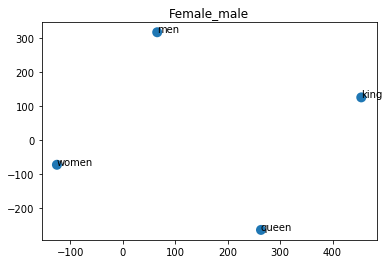

In [158]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
with open("./tweets_data/vocabulary.pkl", "rb") as f:
        vocabulary = pickle.load(f)
        vocab=list(vocabulary)


vectors = get_vectors(female_male)

rev_lookup=get_embed(vectors,embeds)
X_embed= TSNE(n_components=2).fit_transform(rev_lookup)

fig=plt.figure()
plt.subplot(1, 1,1)
plt.scatter(X_embed[:,0],X_embed[:,-1],edgecolors='none',s=100)
    
for i,data in enumerate(female_male):
    plt.annotate(data,(X_embed[i,0],X_embed[i,-1]),size=10)
    
plt.title('Female_male')
plt.show()




### your code here

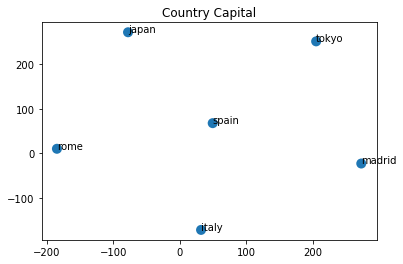

In [175]:
vectors_1 = get_vectors(country_capital)

rev_lookup_1=get_embed(vectors_1,embeds)
X_embed_1= TSNE(n_components=2).fit_transform(rev_lookup_1)

fig=plt.figure()
plt.subplot(1, 1,1)
plt.scatter(X_embed_1[:,0],X_embed_1[:,-1],edgecolors='none',s=100)

for i,data in enumerate(country_capital):
    plt.annotate(data,(X_embed_1[i,0],X_embed_1[i,-1]),size=10)
    

plt.title('Country Capital')
plt.show()



In [154]:
#For full vocab - takes 5 min to run

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
with open("./tweets_data/vocabulary.pkl", "rb") as f:
        vocabulary = pickle.load(f)
        vocab=list(vocabulary)

vectors = get_vectors(vocab)
rev_lookup=get_embed(vectors,embeds)
X_embed= TSNE(n_components=2).fit_transform(rev_lookup)



#### <span style="color:red">TODO: </span> describe your observation of these word vectors

Answer: 
Embeddings are mappings from words to their corresponding vectors. During this process, we obtain the vector index of each word and then the embedding from the embedding matrix trained from the previous section. T-sne is a method of dimensionality reduction. Using T-sne in this case reduces the dimensionality to two and it also aids in the structure of the vector relationships. For example, after running t-sne on the men, women, king, queen list, we can see that king-men is parallel to queen-women. Moreover, the relationship is also almost king=queen-women+men. For the country-capital list, it may by seen that the capital-country pairs can be joined by straight lines that run almost parallel to each other. An interesting observation is any two countries can be joined by a line and this line is (almost) parallel to a line join their respective capitals. Eg.,Rome-spain and italy-madrid. This method of word pairs can have multiple forms and they can be visualized differently but the local relationsip structure will be similar, thus introducing a level of randomness.